# Gastrointestinal disease Detection and classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
tf.config.list_physical_devices(
    device_type=None
)


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [1]:

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Rescaling

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")



In [ ]:
# Removed deprecated TensorFlow logging settings
dataset_path = "unsplit-dataset"

image_size = (224, 224)
batch_size = 64
# Load datasets
train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.4,
    subset="training",
    label_mode="categorical",
    seed=23,
    image_size=image_size,
    batch_size=batch_size)

val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.4,
    subset="validation",
    label_mode="categorical",
    seed=23,
    image_size=image_size,
    batch_size=batch_size)

class_names = train_ds.class_names


normalization_layer = Rescaling(1./255)

# Apply normalization to datasets
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

Found 8000 files belonging to 8 classes.
Using 4800 files for training.
Found 8000 files belonging to 8 classes.
Using 3200 files for validation.


In [6]:
# Split validation dataset into validation and test sets
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

In [7]:
# Optimize dataset loading with prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [8]:
# Build the model
model = Sequential()
base_model = tf.keras.applications.ResNet101V2(
    include_top=False,
    weights="imagenet",
    pooling='max',
    classifier_activation="softmax",  # Changed to None for logits output
)

In [9]:
# Set base model to trainable
for layer in base_model.layers:
        layer.trainable=True

model.add(base_model)
model.add(Flatten())
model.add(Dense(8, activation='softmax'))

In [10]:
# Compile the model
model.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=0.004, beta_1=0.9, beta_2=0.999, epsilon=1e-8),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)        │ (None, 2048)           │    42,626,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        16,392 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,642,952 (162.67 MB)

 Trainable params: 42,545,288 (162.30 MB)

 Non-trainable params: 97,664 (381.50 KB)

In [12]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
best = ModelCheckpoint(filepath="/content/drive/MyDrive/Dataset/best/model_best_val_accuracy.weights.h5",
                        save_weights_only=True, monitor="val_accuracy", mode="max", save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=20)

In [13]:
# Train the model
history = model.fit(train_ds, epochs=2, validation_data=val_ds, callbacks=[reduce_lr, best])

# Save the model
model.save("finalwithhighaccuracy.h5")

Epoch 1/2
75/75 ━━━━━━━━━━━━━━━━━━━━ 1623s 20s/step - accuracy: 0.5629 - loss: 3.1460 - precision: 0.5806 - recall: 0.5303 - val_accuracy: 0.3081 - val_loss: 9.4606 - val_precision: 0.3102 - val_recall: 0.2906 - learning_rate: 0.0010
Epoch 2/2
75/75 ━━━━━━━━━━━━━━━━━━━━ 1572s 21s/step - accuracy: 0.7932 - loss: 0.5778 - precision: 0.8066 - recall: 0.7603 - val_accuracy: 0.7525 - val_loss: 2.5308 - val_precision: 0.7621 - val_recall: 0.7369 - learning_rate: 0.0010


In [36]:

# Extract training history
metrics = history.history
loss = metrics['loss']
val_loss = metrics['val_loss']
accuracy = metrics['accuracy']
val_accuracy = metrics['val_accuracy']
precision = metrics['precision']
val_precision = metrics['val_precision']
recall = metrics['recall']
val_recall = metrics['val_recall']
print(history.history)

{'accuracy': [0.6766666769981384, 0.8387500047683716, 0.8741666674613953, 0.89083331823349, 0.9154166579246521, 0.9320833086967468, 0.9420833587646484, 0.95333331823349, 0.9631249904632568, 0.9552083611488342], 'loss': [1.7118089199066162, 0.4277150332927704, 0.3250695466995239, 0.26652470231056213, 0.2177981287240982, 0.18073035776615143, 0.15263839066028595, 0.12561796605587006, 0.1060020923614502, 0.13012272119522095], 'precision': [0.6894437074661255, 0.8490445613861084, 0.8794341087341309, 0.8950799107551575, 0.9177308082580566, 0.9340728521347046, 0.9436089992523193, 0.9540325999259949, 0.9636743068695068, 0.9561678171157837], 'recall': [0.6558333039283752, 0.8331249952316284, 0.8677083253860474, 0.8868749737739563, 0.9133333563804626, 0.9297916889190674, 0.9412500262260437, 0.9512500166893005, 0.9616666436195374, 0.9543750286102295], 'val_accuracy': [0.1537500023841858, 0.5543749928474426, 0.6756250262260437, 0.8174999952316284, 0.824999988079071, 0.7962499856948853, 0.864374995

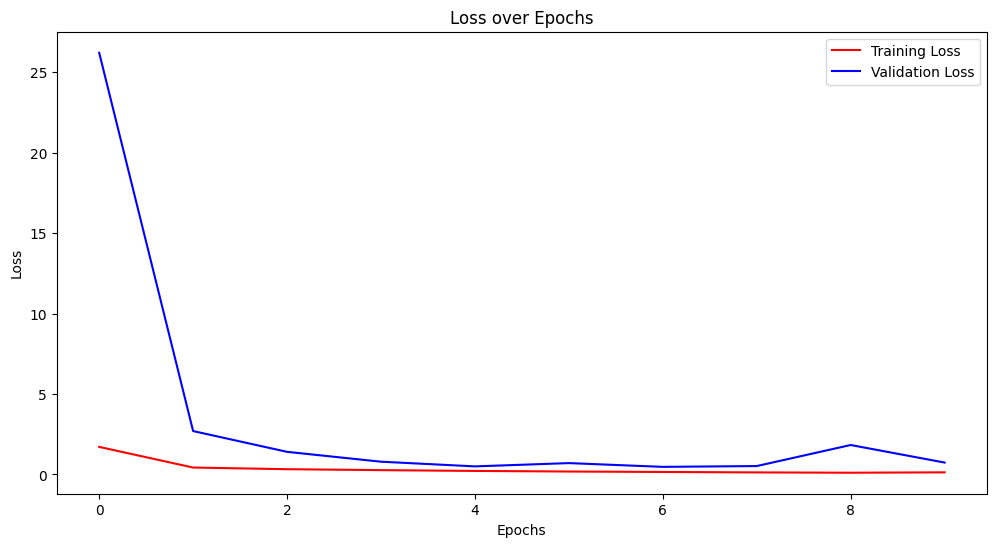

In [37]:
# Calculate F1 scores
f1 = [2 * (p * r) / (p + r + 1e-7) for p, r in zip(precision, recall)]
val_f1 = [2 * (p * r) / (p + r + 1e-7) for p, r in zip(val_precision, val_recall)]

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(loss, label='Training Loss', color='red')
plt.plot(val_loss, label='Validation Loss', color='blue')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




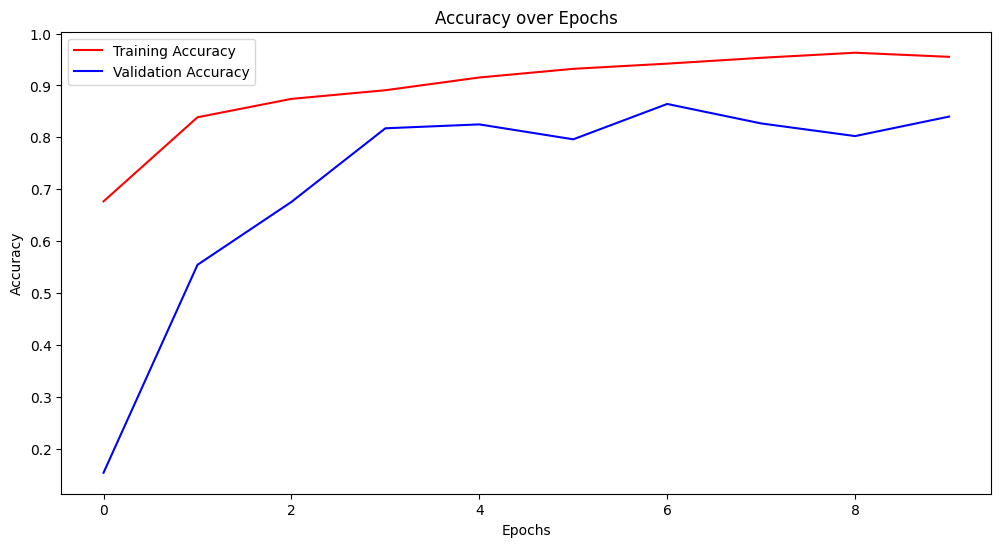

In [38]:
# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(accuracy, label='Training Accuracy', color='red')
plt.plot(val_accuracy, label='Validation Accuracy', color='blue')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



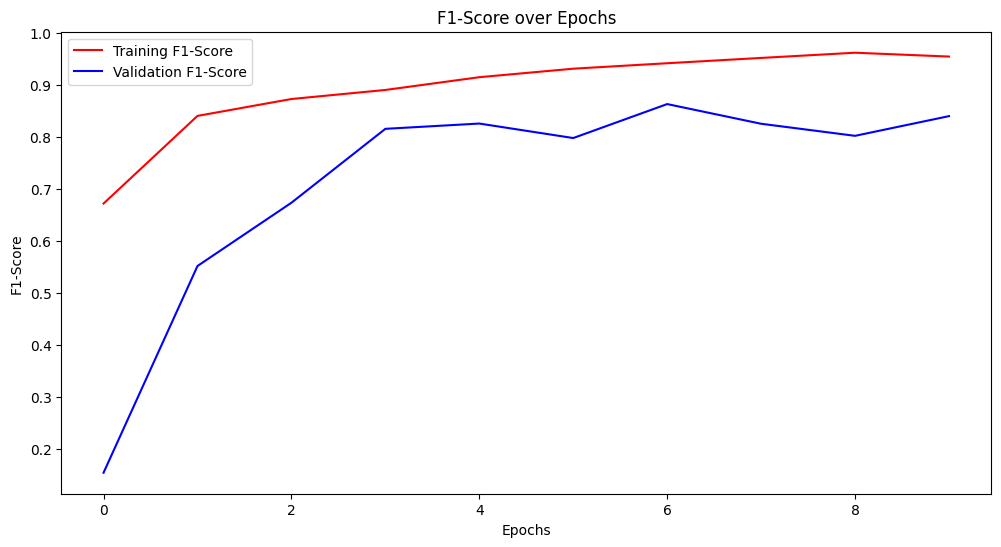

In [39]:
# Plot F1 Score
plt.figure(figsize=(12, 6))
plt.plot(f1, label='Training F1-Score', color='red')
plt.plot(val_f1, label='Validation F1-Score', color='blue')
plt.title('F1-Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()
plt.show()

In [40]:
# Evaluate on test data
true_labels = []
predicted_labels = []

for images, labels in test_ds:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Test Accuracy: {accuracy:.2f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Test Accuracy: 0.82


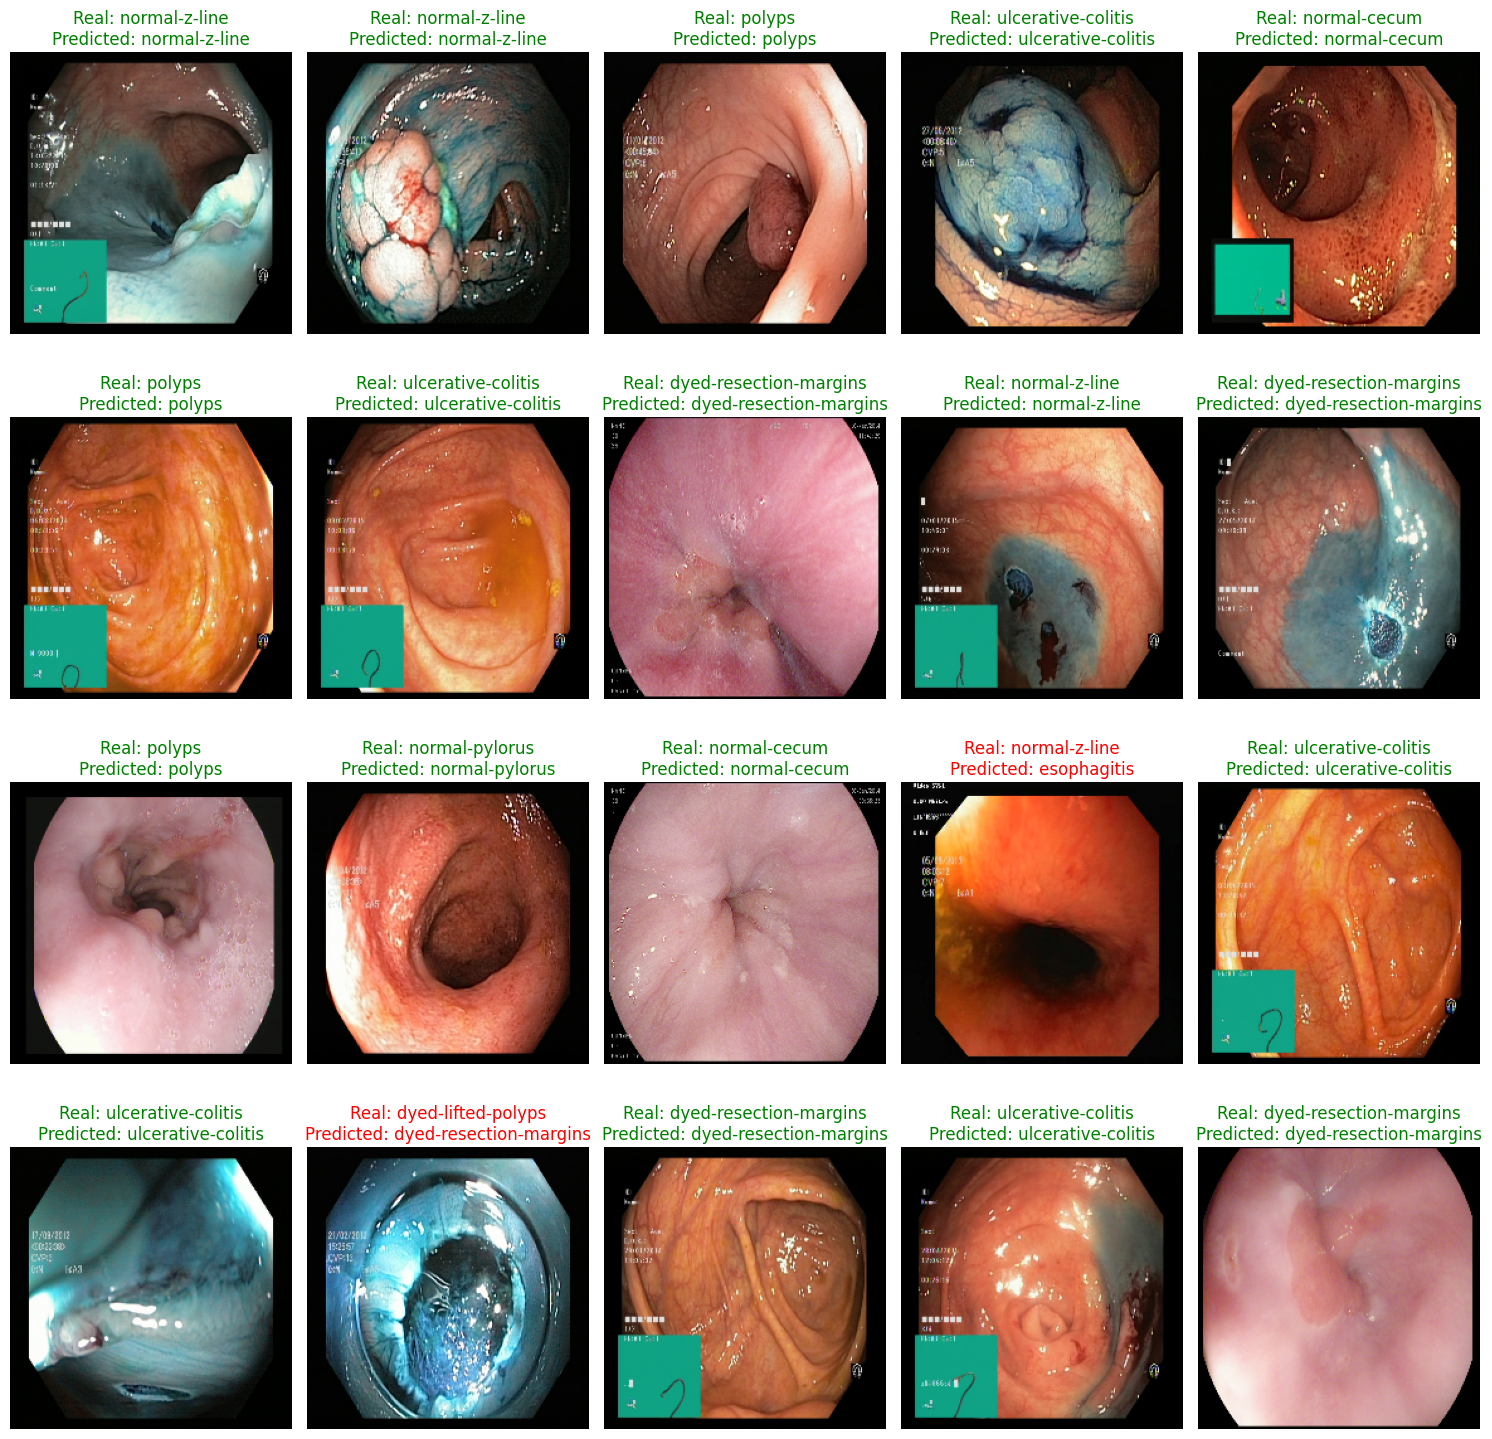

In [41]:
import random
import os

# Convert test_ds to a list of images and labels
class_names = sorted(os.listdir(dataset_path))  # List of class directories

# Convert test_ds to a list of images and labels
test_images = []
test_labels = []

for images, labels in test_ds:
    test_images.extend(images.numpy())
    test_labels.extend(labels.numpy())

# Convert to numpy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Select 30 random indices from the test dataset
num_images_to_display = 20
random_indices = random.sample(range(len(true_labels)), num_images_to_display)

# Display the real and predicted labels for the selected images
plt.figure(figsize=(15, 15))
for i, idx in enumerate(random_indices):
    plt.subplot(4, 5, i + 1)  # 6 rows, 5 columns
    plt.imshow(test_images[idx].astype("uint8"))  # Display the image

    # Get the real and predicted class names
    real_class = class_names[true_labels[idx]]
    predicted_class = class_names[predicted_labels[idx]]

    # Set title color based on prediction accuracy
    if true_labels[idx] == predicted_labels[idx]:
        title_color = 'green'  # Correct prediction
    else:
        title_color = 'red'    # Incorrect prediction

    plt.title(f"Real: {real_class}\nPredicted: {predicted_class}", color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.show()

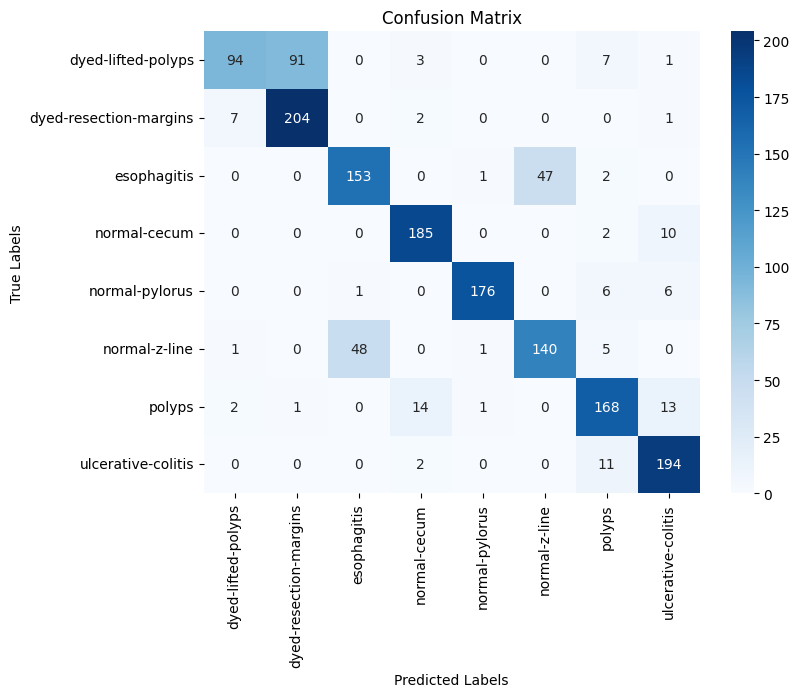


Classification Report:
                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.90      0.48      0.63       196
dyed-resection-margins       0.69      0.95      0.80       214
           esophagitis       0.76      0.75      0.76       203
          normal-cecum       0.90      0.94      0.92       197
        normal-pylorus       0.98      0.93      0.96       189
         normal-z-line       0.75      0.72      0.73       195
                polyps       0.84      0.84      0.84       199
    ulcerative-colitis       0.86      0.94      0.90       207

              accuracy                           0.82      1600
             macro avg       0.83      0.82      0.82      1600
          weighted avg       0.83      0.82      0.82      1600



In [42]:

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Softmax Probabilities for 8 Classes:
dyed-lifted-polyps: 0.1029
dyed-resection-margins: 0.1029
esophagitis: 0.1031
normal-cecum: 0.1029
normal-pylorus: 0.1029
normal-z-line: 0.2793
polyps: 0.1029
ulcerative-colitis: 0.1029
Predicted Class: normal-z-line


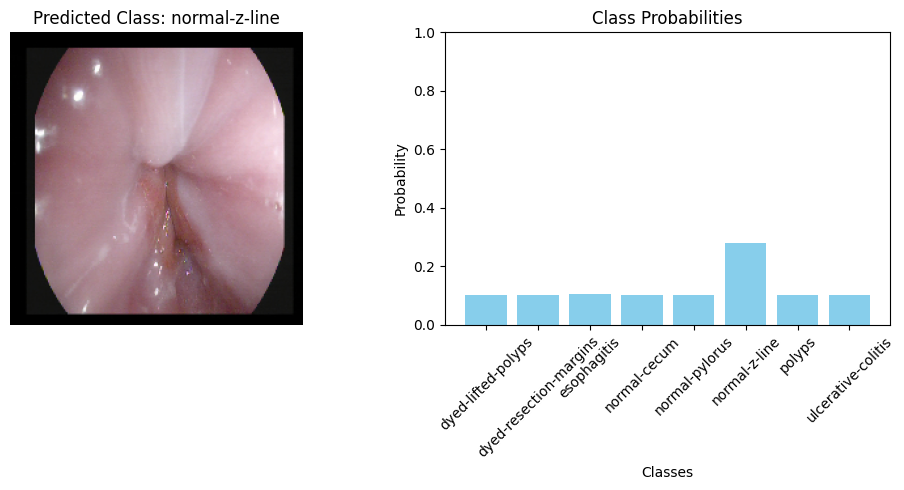

In [47]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def preprocess_image(image_path, target_size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    # img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Normalize to [0, 1]
    return np.expand_dims(img, axis=0)

# Test image path (replace with an actual image path from your dataset)
test_image_path = '/content/drive/MyDrive/Dataset/unsplit-dataset/normal-z-line/03be9506-bf4a-42e5-b18b-ec8388860fae.jpg'  # Example

# Preprocess the test image
test_image = preprocess_image(test_image_path)

# Predict logits from the model
logits = model.predict(test_image)

# Apply Softmax to get probabilities
softmax_values = tf.nn.softmax(logits[0]).numpy()

# Display class probabilities
print("Softmax Probabilities for 8 Classes:")
for class_name, prob in zip(class_names, softmax_values):
    print(f"{class_name}: {prob:.4f}")

# Get the predicted class
predicted_class = class_names[np.argmax(softmax_values)]
print(f"Predicted Class: {predicted_class}")

# Plot the image and the softmax probabilities
plt.figure(figsize=(10, 5))

# Display the image
plt.subplot(1, 2, 1)
plt.imshow(test_image[0])  # Remove the batch dimension
plt.title(f"Predicted Class: {predicted_class}")
plt.axis('off')

# Display the softmax probabilities as a bar graph
plt.subplot(1, 2, 2)
plt.bar(class_names, softmax_values, color='skyblue')
plt.title('Class Probabilities')
plt.xlabel('Classes')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Set y-axis limits to [0, 1]

# Show the plot
plt.tight_layout()
plt.show()

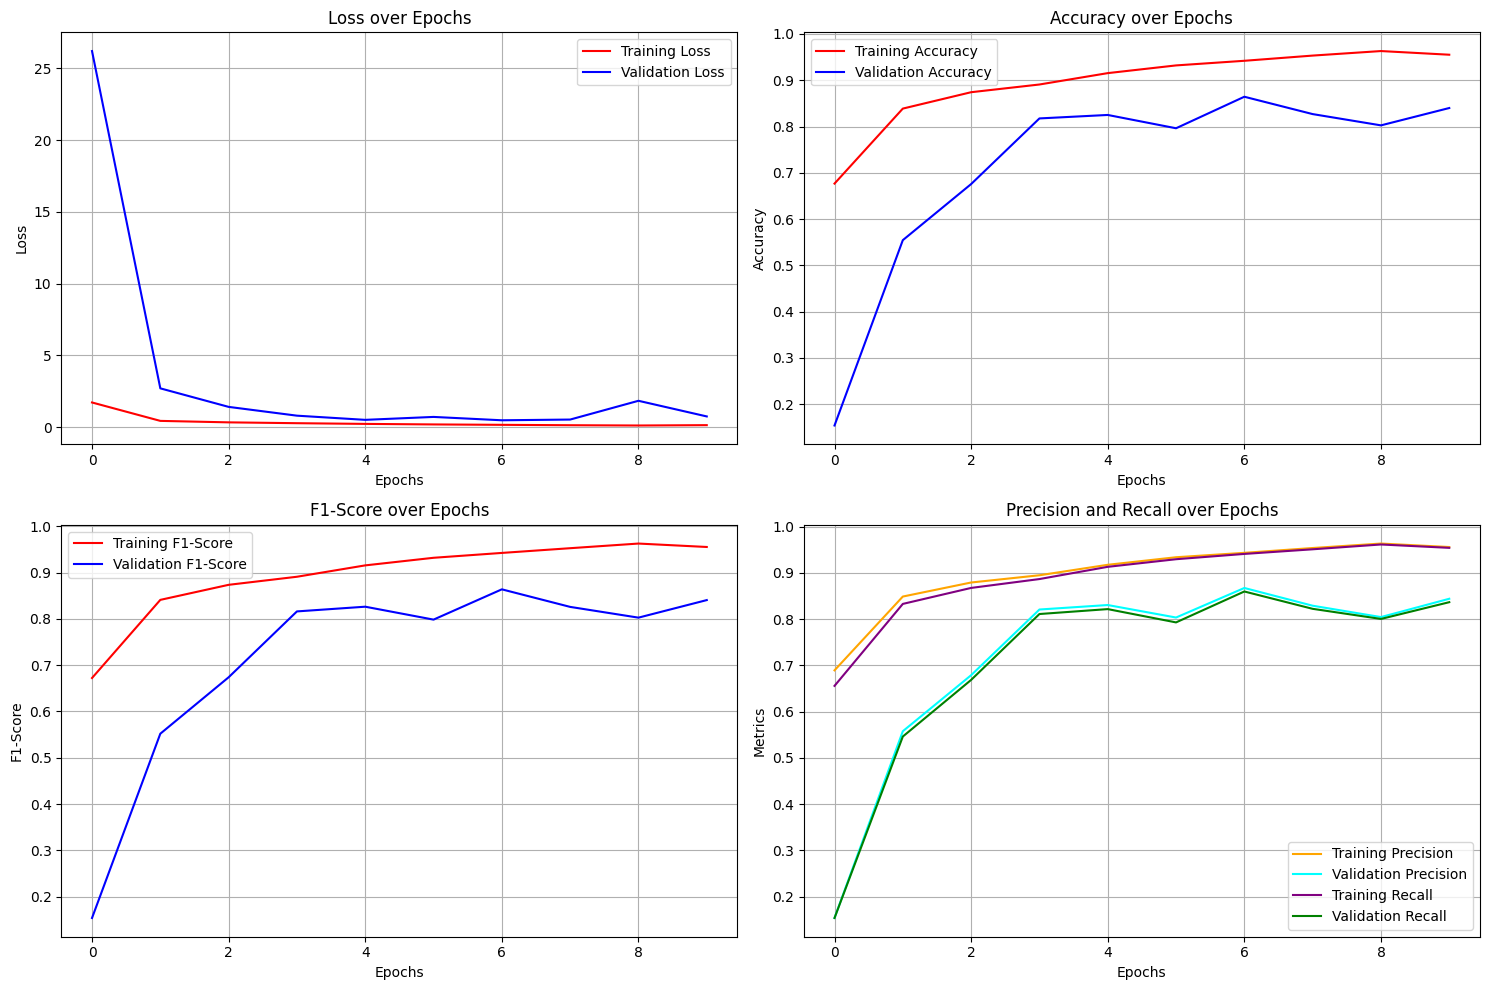

In [48]:
# Overall analysis

# Extract metrics from the training history
metrics = history.history

# Training and validation metrics
loss = metrics['loss']
val_loss = metrics['val_loss']
accuracy = metrics['accuracy']
val_accuracy = metrics['val_accuracy']
precision = metrics['precision']
val_precision = metrics['val_precision']
recall = metrics['recall']
val_recall = metrics['val_recall']

# Calculate F1-Score for Training and Validation
f1 = [2 * (p * r) / (p + r + 1e-7) for p, r in zip(precision, recall)]
val_f1 = [2 * (p * r) / (p + r + 1e-7) for p, r in zip(val_precision, val_recall)]

# Create a figure for overall performance
plt.figure(figsize=(15, 10))

# Subplot 1: Loss
plt.subplot(2, 2, 1)
plt.plot(loss, label='Training Loss', color='red')
plt.plot(val_loss, label='Validation Loss', color='blue')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Subplot 2: Accuracy
plt.subplot(2, 2, 2)
plt.plot(accuracy, label='Training Accuracy', color='red')
plt.plot(val_accuracy, label='Validation Accuracy', color='blue')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Subplot 3: F1-Score
plt.subplot(2, 2, 3)
plt.plot(f1, label='Training F1-Score', color='red')
plt.plot(val_f1, label='Validation F1-Score', color='blue')
plt.title('F1-Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()
plt.grid()

# Subplot 4: Precision and Recall
plt.subplot(2, 2, 4)
plt.plot(precision, label='Training Precision', color='orange')
plt.plot(val_precision, label='Validation Precision', color='cyan')
plt.plot(recall, label='Training Recall', color='purple')
plt.plot(val_recall, label='Validation Recall', color='green')
plt.title('Precision and Recall over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.grid()

# Adjust layout
plt.tight_layout()
plt.show()
